In [3]:
import sys
sys.path.append('/Users/evatakou/noise_est')
import stim
import numpy as np
import pymatching
from pymatching import Matching
import xarray as xr
from circuit_SC_varying_error_rates import *
from tqdm import tqdm

In [4]:
from sims.surface_code_bare_ancilla.construct_dem import get_measurement_data,project_data_meas,get_initial_state,surface_code_DEM, get_defects
from sims.surface_code_bare_ancilla.estimation_funcs_surface_code import *
from utilities.general_utils import avg_vi,avg_vivj,avg_vivj_alt
from utilities.utils_for_decoding import decode_both_dems_same_data


In [5]:
def get_DEM(distance,num_rounds,num_shots,p_data,p_anc,std,p_G):

    num_ancilla   = distance*(distance-1)
    
    circuit       = planar_surface_code_circuit_X_memory(distance,num_rounds,p_data,p_anc,std,p_G)

    defects_matrix,data_qubit_meas = get_defects(circuit,distance,num_shots,num_rounds)
    vi_mean                        = avg_vi(defects_matrix)
    # vivj_mean                      = avg_vivj_alt(defects_matrix.data)
    
    # pij_time        = estimate_time_edge_probs_alt_V2(num_rounds,num_ancilla,vi_mean,vivj_mean)
    # pij_bulk,pij_bd = estimate_bulk_and_bd_edge_probs(num_rounds,num_ancilla,distance,vi_mean,vivj_mean,pij_time)

    pij_time        = estimate_time_edge_probs_alt_V2(num_rounds,num_ancilla,defects_matrix,vi_mean)
    pij_bulk,pij_bd = estimate_bulk_and_bd_edge_probs_alt_Final(num_rounds,num_ancilla,distance,defects_matrix,pij_time,vi_mean)

    my_DEM = surface_code_DEM(pij_bulk,pij_bd,pij_time,circuit.detector_error_model(flatten_loops=True))

    return my_DEM,circuit





In [6]:
def decode_both_dems_same_data(reconstructed_DEM:stim.DetectorErrorModel,circuit:stim.Circuit, detector_error_model: stim.DetectorErrorModel ,num_shots:int):
    '''
    Decode stim's DEM obtained from a circuit and a reconstructed DEM using MWPM, and on the same data.

    Inputs: 
        my_DEM:    Reconstructed detector error model
        circuit:   The true stim circuit (w/ variations on data/ancilla qubits)
        detector_error_model: stim's detector error model for the case of all error rates of data being equal to p, and all error rates of ancilla being equal to q
        num_shots: # of shots to use to decode
    Output:
        num_errors_est:    Total # of logical errors obtained by decoding the reconstructed DEM
        num_errors_stim:   Total # of logical errors obtained by decoding stim's DEM
    '''
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    # detector_error_model = circuit.detector_error_model(flatten_loops=True) 
    matcher              = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors_stim =   np.sum(~np.all(observable_flips == predictions, axis=1))  

    #Now do the same for my model.

    matcher     = pymatching.Matching.from_detector_error_model(reconstructed_DEM)
    predictions = matcher.decode_batch(detection_events) #use same detection events

    num_errors_est =   np.sum(~np.all(observable_flips == predictions, axis=1))  

    return num_errors_est,num_errors_stim


In [ ]:
#For multiple configurations per p and q, which are averaged

from joblib import Parallel, delayed
import numpy as np

def compute_errors(distance, num_rounds, num_shots, p, q, std, p_G, iterMax):
    print(f"  Processing p_G={p_G:.4f} for p={p:.4f}")
    errors_mine = []
    errors_stim = []

    for _ in range(iterMax):
        my_DEM, circuit_true = get_DEM(distance, num_rounds, num_shots, p, q, std, p_G)
        circuit2 = planar_surface_code_circuit_X_memory(distance, num_rounds, p, q, std=0, p_depol_gate=p_G)
        stims_DEM = circuit2.detector_error_model(flatten_loops=True)
        err_my, err_stim = decode_both_dems_same_data(my_DEM, circuit_true, stims_DEM, num_shots)
        errors_mine.append(err_my / num_shots)
        errors_stim.append(err_stim / num_shots)

    return np.mean(errors_mine), np.mean(errors_stim), np.std(errors_mine), np.std(errors_stim)

def get_average_logical_error_rate_per_p_and_q(std, distance, num_shots, num_vals, iterMax):
    
    prange_data = np.linspace(1e-3, 0.01, num_vals)
    prange_gate = prange_data    
    num_rounds  = distance

    all_LE_mine = []
    all_LE_stim = []

    all_std_mine = []
    all_std_stim = []


    for p in prange_data:
        q = p
        print(f"\nProcessing p={p:.4f}...")

        results = Parallel(n_jobs=-1, backend="loky")(
            delayed(compute_errors)(distance, num_rounds, num_shots, p, q, std, p_G, iterMax)
            for p_G in prange_gate
        )

        temp_mine, temp_stim,temp_std_mine,temp_std_stim = zip(*results)
        all_LE_mine.append(list(temp_mine))
        all_LE_stim.append(list(temp_stim))
        all_std_mine.append(temp_std_mine)
        all_std_stim.append(temp_std_stim)

    print("\nDone with all computations.")
    return prange_data, prange_gate, all_LE_mine, all_LE_stim,all_std_mine,all_std_stim


std       = 5*10**(-4)
distance  = 3
num_shots = 5*10**6
num_vals  = 10
iterMax   = 50

#~8-9 mins for 2 iters 
#30 iters ~1.5-1.6 hrs
#40 iters ~2.3 hrs
#50 iters ~153 mins (2.55 hrs)



prange_data,prange_gate,all_LE_mine,all_LE_stim,all_std_mine,all_std_stim  = \
    get_average_logical_error_rate_per_p_and_q(std,distance,num_shots,num_vals,iterMax)




Processing p=0.0010...
  Processing p_G=0.0050 for p=0.0010
  Processing p_G=0.0040 for p=0.0010
  Processing p_G=0.0080 for p=0.0010
  Processing p_G=0.0070 for p=0.0010
  Processing p_G=0.0030 for p=0.0010
  Processing p_G=0.0060 for p=0.0010
  Processing p_G=0.0020 for p=0.0010
  Processing p_G=0.0010 for p=0.0010
  Processing p_G=0.0090 for p=0.0010
  Processing p_G=0.0100 for p=0.0010

Processing p=0.0020...
  Processing p_G=0.0010 for p=0.0020
  Processing p_G=0.0020 for p=0.0020
  Processing p_G=0.0030 for p=0.0020
  Processing p_G=0.0040 for p=0.0020
  Processing p_G=0.0060 for p=0.0020
  Processing p_G=0.0050 for p=0.0020
  Processing p_G=0.0070 for p=0.0020
  Processing p_G=0.0080 for p=0.0020
  Processing p_G=0.0090 for p=0.0020
  Processing p_G=0.0100 for p=0.0020

Processing p=0.0030...
  Processing p_G=0.0010 for p=0.0030
  Processing p_G=0.0020 for p=0.0030
  Processing p_G=0.0030 for p=0.0030
  Processing p_G=0.0040 for p=0.0030
  Processing p_G=0.0050 for p=0.0030
  P

In [21]:
improvement_factor = []

 
for k in range(len(prange_data)):
    
    temp1 = all_LE_mine[k]
    temp2 = all_LE_stim[k]
    temp  = []

    for l in range(len(prange_gate)):

        temp.append( abs(temp1[l]-temp2[l])/temp2[l]*100 )  #(xf-x)/x
        # temp.append(temp2[l]/temp1[l]) 

        if temp2[l]<temp1[l]:
            print("stim performs better for (p,q) =",(prange_data[k],prange_gate[l]))
            print("stim:",temp2[l],"ours:",temp1[l])

        
            

    improvement_factor.append(temp)

print("max improvement factor:",max(max(improvement_factor)))
print("min improvement factor:",min(min(improvement_factor)))


max improvement factor: 18.25029255187644
min improvement factor: 4.134992307738923


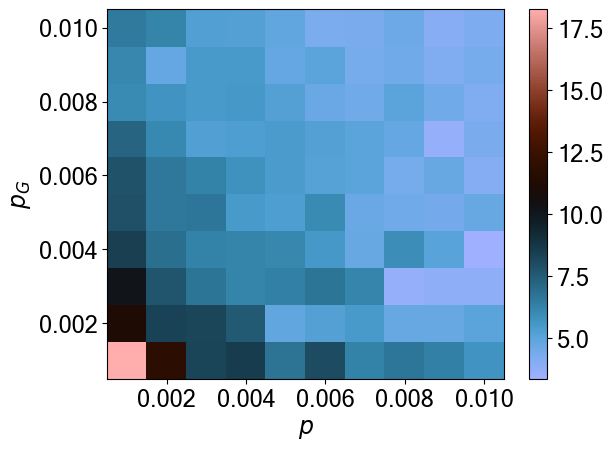

In [22]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy import *
import scipy
import scipy.interpolate
import matplotlib

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"   

fig, ax = plt.subplots()


X, Y    = np.meshgrid(prange_data, prange_gate)
Z       = np.array(improvement_factor)


# vmin=1.012510355791058, vmax=1.1152711081196527 
plt.pcolormesh(X, Y, Z , cmap=cm.berlin,linewidth=0, antialiased=False,snap=False)#,shading='gouraud'


plt.colorbar()
plt.xlabel("$p$")
plt.ylabel("$p_G$")

fig.savefig("Improvement_factor_d_3_r_3_N_5_10_6_std_5_10_minus_4_repeat_50.pdf",bbox_inches='tight')




In [29]:
print("min std in our logical error rate:",min(min(all_std_mine)))
print("max std in our logical error rate:",max(max(all_std_mine)))

min std in our logical error rate: 4.2784034405371356e-05
max std in our logical error rate: 0.0005123978036643014


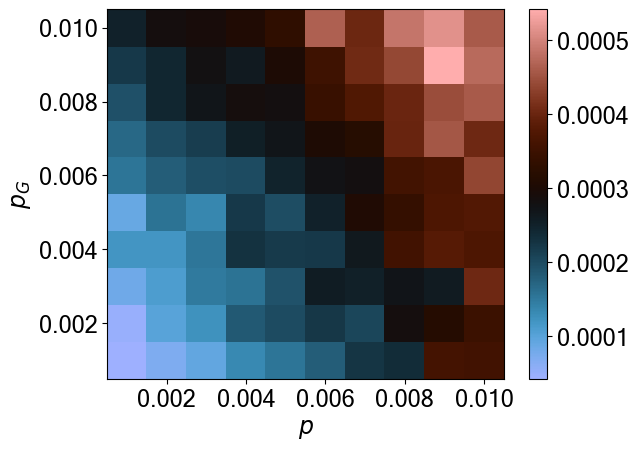

In [23]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy import *
import scipy
import scipy.interpolate
import matplotlib

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"   

fig, ax = plt.subplots()


X, Y    = np.meshgrid(prange_data, prange_gate)
Z       = np.array(all_std_mine)



plt.pcolormesh(X, Y, Z , cmap=cm.berlin,linewidth=0, antialiased=False,snap=False)#,shading='gouraud'

plt.colorbar()
plt.xlabel("$p$")
plt.ylabel("$p_G$")

fig.savefig("std_of_our_LE_d_3_r_3_N_5_10_6_std_5_10_minus_4_repeat_50.pdf",bbox_inches='tight')




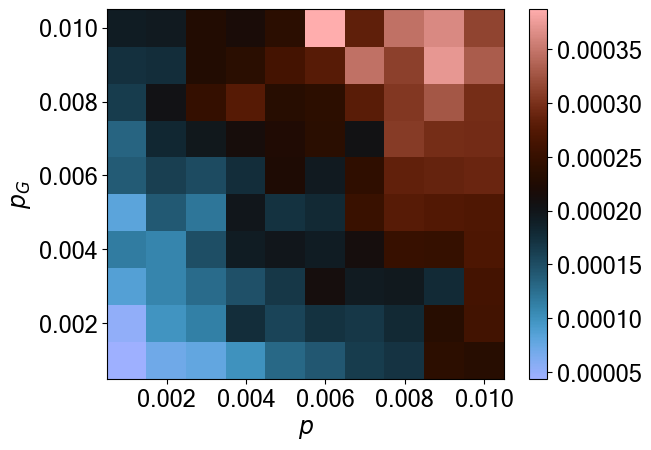

In [24]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy import *
import scipy
import scipy.interpolate
import matplotlib

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"   

fig, ax = plt.subplots()


X, Y    = np.meshgrid(prange_data, prange_gate)
Z       = np.array(all_std_stim)



plt.pcolormesh(X, Y, Z , cmap=cm.berlin,linewidth=0, antialiased=False,snap=False)#,shading='gouraud'

plt.colorbar()
plt.xlabel("$p$")
plt.ylabel("$p_G$")

fig.savefig("std_of_our_stim_d_3_r_3_N_5_10_6_std_5_10_minus_4_repeat_50.pdf",bbox_inches='tight')




In [25]:
with open("stims_for_d_3_r_3_std_5_10_minus_4_N_5_10__6_repeat_50.txt", "w") as file:
    file.write(str(all_LE_stim))
with open("our_for_d_3_r_3_std_5_10_minus_4_N_5_10__6_repeat_50.txt", "w") as file:
    file.write(str(all_LE_mine))    
with open("ps_for_d_3_r_3_std_5_10_minus_4_N_5_10__6_repeat_50.txt", "w") as file:
    file.write(str(prange_data))        
with open("pGs_for_d_3_r_3_std_5_10_minus_4_N_5_10__6_repeat_50.txt", "w") as file:
    file.write(str(prange_gate))            
with open("std_our_DEM_for_d_3_r_3_std_5_10_minus_4_N_5_10__6_repeat_50.txt", "w") as file:
    file.write(str(all_std_mine))                
with open("std_stim_for_d_3_r_3_std_5_10_minus_4_N_5_10__6_repeat_50.txt", "w") as file:
    file.write(str(all_std_stim))                    